In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math

%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
qids = [6027, 6109, 3261, 2801]
qs = Query.objects.filter(pk__in=qids)
p = qs.first().project

docs = Doc.objects.filter(query__in=qs, content__iregex='\w').values_list('pk', flat=True)

seen = set(DocOwnership.objects.filter(
    query__project=p, 
    doc__in=docs,
    relevant__gt=0
).values_list('doc__pk', flat=True))

man_added = set(Doc.objects.filter(query=3261).values_list('pk',flat=True)) & set(docs)

seen = seen | man_added



seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

2559

In [3]:
seen_docs.filter(
    docproject__project=p
).values('docproject__relevant').annotate(
    n = Count('pk')
)

<QuerySet [{'docproject__relevant': 1, 'n': 447}, {'docproject__relevant': 2, 'n': 1848}, {'docproject__relevant': 3, 'n': 264}]>

In [4]:
maybes = seen_docs.filter(
    docproject__project=p,
    docproject__relevant=3
)

m = maybes.filter(
    docownership__query__project=p,
    docownership__relevant=3
).distinct()
print(f"maybe: {m.count()}")

y = maybes.filter(
    docownership__query__project=p,
    docownership__relevant=1
).distinct()
print(f"yes: {y.count()}")

n = maybes.filter(
    docownership__query__project=p,
    docownership__relevant=2
).distinct()
print(f"no: {n.count()}")


yn = set(y.values_list('pk',flat=True)) - set(m.values_list('pk', flat=True))
ym = set(y.values_list('pk',flat=True)) - set(n.values_list('pk', flat=True))
nm = set(n.values_list('pk',flat=True)) - set(y.values_list('pk', flat=True))
mm = set(m.values_list('pk', flat=True)) \
    - set(y.values_list('pk',flat=True)) \
    - set(n.values_list('pk',flat=True))

print(f"yes no: {len(yn)}")

print(f"yes maybe: {len(ym)}")

print(f"no maybe: {len(nm)}")

print(f"only maybe: {len(mm)}")


maybe: 194
yes: 87
no: 85
yes no: 66
yes maybe: 22
no maybe: 20
only maybe: 157


In [5]:
doubles = 0

for d in maybes:
    dos = DocOwnership.objects.filter(
        doc=d,
        query__in=qs,
        relevant__gt=0
    )
    ucs = dos.values('user').annotate(
        n = Count('pk')
    )
    for u in ucs:
        if u['n'] > 1:
            dos = dos.filter(user=u['user'])
            if dos[0].relevant != dos[1].relevant:
                #print(dos.values('tag'))          
                doubles += 1
            
print(doubles)

48


In [6]:
unseen_docs = docs.exclude(pk__in=seen)

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0
unseen_df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,185318,Low-income housing constitutes an important bu...,Reducing energy consumption in low income publ...,Occupant behavior; Residential energy efficien...,"[Energy & Fuels; Engineering, Chemical]",0,0
1,254050,Renewable energy is increasingly replacing car...,Flexible electricity tariffs: Power and energy...,Electricity tariff; Flexible power pricing; De...,[Thermodynamics; Energy & Fuels],0,0
2,290141,"Usage ecodrifts, which refer to non-optimal us...",A method for identifying and quantifying Usage...,Usage EcoDrift; Non-optimal usages; Sustainabl...,[Green & Sustainable Science & Technology; Eng...,0,0
3,634572,We describe an approach to dynamically couple ...,A bioenergetlics-based population dynamics mod...,lower trophic level model; NEMURO; NEMURO.FISH...,[Ecology],0,0
4,740339,Studies have shown that building energy demand...,The effect of real-time context-aware feedback...,Real-time feedback; Occupant behaviour; Therma...,[Construction & Building Technology; Energy & ...,0,0


In [7]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])
    if d.id in man_added:
        r['relevant'] = 1
        r_docs.append(r)
        continue
    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if len(set(dos))==1:
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
seen_df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,809349,Technologies providing opportunities for home ...,Categories and functionality of smart home tec...,Home energy management; Energy efficiency; Sma...,[Construction & Building Technology; Engineeri...,0,1
1,882482,"Smart meters, as a new technical innovation, a...",Smart Meter's feedback and the potential for e...,None,None,1,1
2,1674312,Cointegration techniques receive growing atten...,The relevance of irreversible efficiency impro...,None,"[Energy & Fuels; Engineering, Environmental; E...",0,1
3,808680,"While there is extensive research on feedback,...",Sequential and myopic: On the use of feedback ...,Feedback; optimisation; goal conflict; cogniti...,"[Psychology, Experimental]",1,1
4,354533,Sorption heat storage can potentially store th...,Energy density and storage capacity cost compa...,Sorption thermal energy storage; Solid sorptio...,[Green & Sustainable Science & Technology; Ene...,0,1


In [8]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,408597,Power-line communications (PLC) have proven to...,Power-line communications for smart grid: Prog...,Distributed-power system; Power-line communica...,[Green & Sustainable Science & Technology; Ene...,0,0
1,773157,By employing an Earth system model of intermed...,Lead-lag relationships between global mean tem...,Climate change origins; Climate-carbon cycle i...,"[Geography, Physical; Geosciences, Multidiscip...",0,1
2,1077007,Efficient water and energy use in water distri...,Smart metering use cases to increase water and...,information and communication technology; smar...,"[Engineering, Environmental; Environmental Sci...",0,0
3,1072165,Dynamic facades with high performance glazing ...,Model-based shading and lighting controls cons...,Model-based control; Shading; Lighting; Visual...,[Energy & Fuels],0,0
4,36398,This study describes a framework to attribute ...,Emissions from residential combustion consider...,Residential combustion; Traditional biofuel; E...,[Environmental Sciences; Meteorology & Atmosph...,0,0


In [9]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


Int64Index([    1,    20,    30,    78,    98,    99,   128,   130,   158,
              182,
            ...
            46403, 46423, 46424, 46435, 46436, 46444, 46474, 46486, 46581,
            46599],
           dtype='int64', length=2377)
Int64Index([43485, 15602, 30201, 19883,  5932, 41645,  3078, 19942,  3212,
             7515,
            ...
            23176, 11803, 30915, 26536,  4712, 43384, 38352,  1259, 26991,
            23183],
           dtype='int64', length=1902)


In [10]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.6, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
ab_X = vec.fit_transform(df['content'])

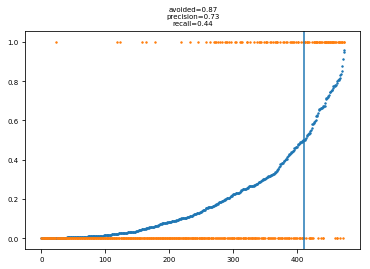

In [11]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots()
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

In [12]:
model = {}
model['p'] = []
model['r'] = []
model['e'] = []
model['i'] = []

kf = KFold(n_splits=5)

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    clf = MultinomialNB(alpha=0.1)
    clf.fit(ab_X[k_train],y[k_train])
    predictions = clf.predict(ab_X[k_test])
    model['e'].append(clf.score(ab_X[k_test],y[k_test]))
    # Precision
    model['p'].append(precision_score(predictions,y[k_test]))
    # Recall
    model['r'].append(recall_score(predictions,y[k_test]))
    #print(k_train)
    

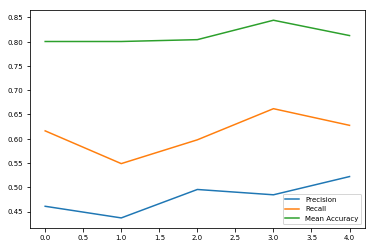

In [13]:
fig, ax = plt.subplots()
ax.plot(model['p'],label="Precision")
ax.plot(model['r'],label="Recall")
ax.plot(model['e'],label="Mean Accuracy")

plt.legend()

In [14]:
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    for model in models:
        clf = model['model']
        i+=1
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

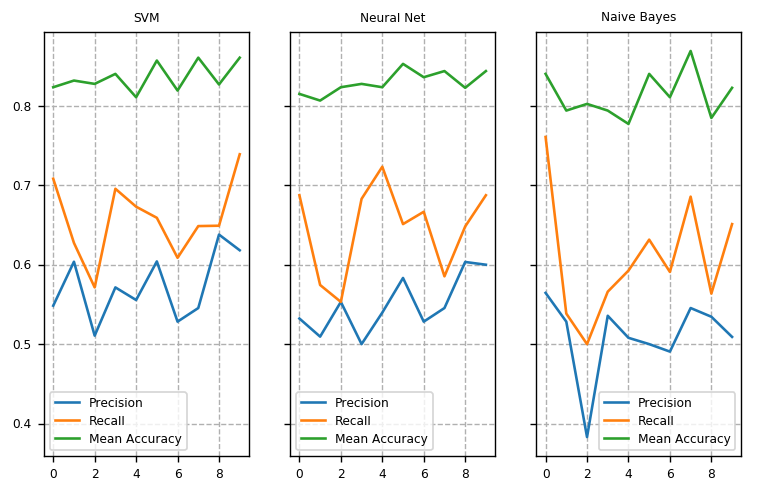

In [15]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.plot(model['p'],label="Precision")
    ax.plot(model['r'],label="Recall")
    ax.plot(model['e'],label="Mean Accuracy")
    
    ax.set_title(model['title'])
    ax.grid()
    ax.legend()

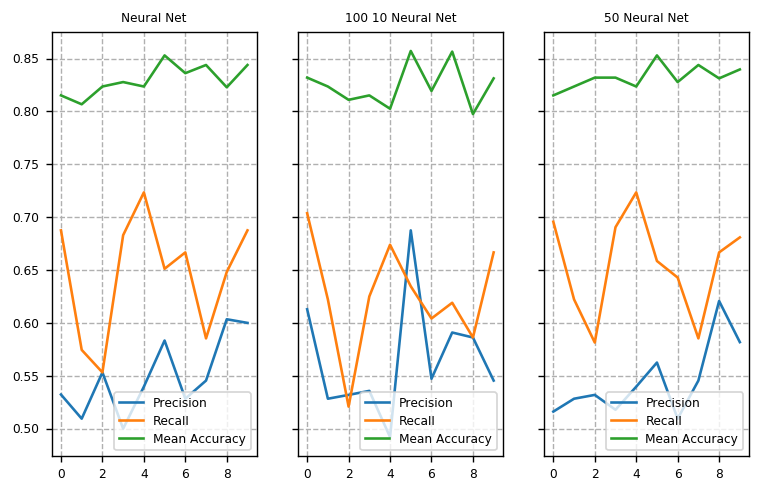

In [16]:
models = [
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title':"100 10 Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(100,10), 
            random_state=1
        )
    },
    {
        'title':"50 Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(50), 
            random_state=1
        )
    },
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    for model in models:
        clf = model['model']
        i+=1
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))
        
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.plot(model['p'],label="Precision")
    ax.plot(model['r'],label="Recall")
    ax.plot(model['e'],label="Mean Accuracy")
    
    ax.set_title(model['title'])
    ax.grid()
    ax.legend()

In [17]:
clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [18]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
for i, p in enumerate(y_pred[:,1]):
    ind = unseen_index[i]
    break
y_pred.shape

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(44227, 2)

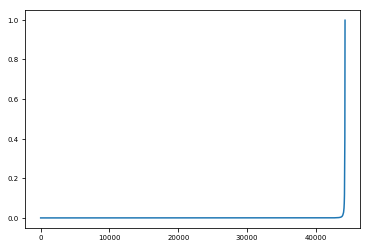

In [19]:
pdf = df.sort_values('prediction').reset_index(drop=True)
plt.plot(pdf.index,pdf['prediction'])

In [20]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=6027)
tag = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()
uc = q.users.count()
for i, row in df.sort_values('prediction',ascending=False).head(750).reset_index(drop=True).iterrows():#.sort_values('prediction').head(500).iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    u = q.users.all().order_by('id')[i % uc]
    do = DocOwnership(
        doc=d,
        user=u,
        query=q,
        tag=tag
    )
    do.save()

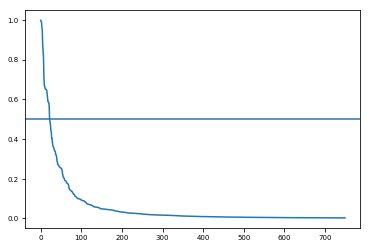

In [23]:
pdf = df.sort_values('prediction',ascending=False).head(750).reset_index(drop=True)
plt.plot(pdf.index,pdf['prediction'])
plt.axhline(0.5)

In [22]:
df.to_csv(f'doctables/predictions_{now}',index=False)